# Fractal Market Memory
--This is where the explanation will go--

In [146]:
### IMPORTS

# Standard library
from datetime import datetime
import warnings

# Third-party libraries
# >> python -m pip install -U --extra-index-url https://download.pytorch.org/whl/cpu numpy pandas requests matplotlib scipy scikit-learn arch statsmodels torch

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import torch
from scipy.stats import genpareto, kurtosis
from sklearn.linear_model import LinearRegression
from arch import arch_model
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Local modules
from ARCHIVE.V1.V1_secret import API_TOKEN

# Config
warnings.filterwarnings("ignore", category=ConvergenceWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [147]:
### LOGGING

import json, time, logging

class Config:
    LOG_DIR = "logs"
    SCR_DIR = "screenshots"

class JsonFormatter(logging.Formatter):
    """
    True JSON formatter: includes ISO-8601 timestamp, source, and supports exceptions.
    """
    def format(self, record: logging.LogRecord) -> str:
        base = {
            "time": self.formatTime(record),
            "level": record.levelname,
            "logger": record.name,
            "module": record.module,
            "func": record.funcName,
            "line": record.lineno,
            "message": record.getMessage(),
        }
        if record.exc_info:
            base["exc_info"] = self.formatException(record.exc_info)
        return json.dumps(base, ensure_ascii=False)

    def formatTime(self, record, datefmt=None):
        # ISO-8601 with milliseconds
        t = self.converter(record.created) if hasattr(self, "converter") else time.localtime(record.created)
        s = time.strftime("%Y-%m-%dT%H:%M:%S", t)
        return f"{s}.{int(record.msecs):03d}"

class Logger:
    """
    Structured JSON logging to console (INFO) + rotating file (DEBUG).
    Idempotent: calling setup() multiple times will not add duplicate handlers.
    """
    @staticmethod
    def setup(name: str = "fractal",
              log_dir: str = Config.LOG_DIR,
              max_bytes: int = 5_000_000,
              backups: int = 3,
              console_level: int = logging.INFO,
              file_level: int = logging.DEBUG) -> logging.Logger:

        logger = logging.getLogger(name)
        logger.setLevel(logging.DEBUG)
        logger.propagate = False  # avoid double logs via root

        # If already configured, return as-is
        if getattr(logger, "_fractal_configured", False):
            return logger

        fmt = JsonFormatter()

        # Console handler
        ch = logging.StreamHandler()
        ch.setLevel(console_level)
        ch.setFormatter(fmt)
        logger.addHandler(ch)

        logger._fractal_configured = True
        return logger

def log_method(fn):
    """
    Decorator: logs entry/exit + elapsed time; captures exceptions with traceback.
    Assumes 'self.logger' exists; otherwise falls back to 'fractal' logger.
    """
    import functools, time as _time
    @functools.wraps(fn)
    def wrapper(self, *args, **kwargs):
        logger = getattr(self, "logger", logging.getLogger("fractal"))
        name = f"{self.__class__.__name__}.{fn.__name__}"
        logger.info(f"▶ Starting {name}")
        start = _time.time()
        try:
            result = fn(self, *args, **kwargs)
            elapsed = _time.time() - start
            logger.info(f"✔ Finished {name} in {elapsed:.2f}s")
            return result
        except Exception:
            elapsed = _time.time() - start
            logger.exception(f"✖ Error in {name} after {elapsed:.2f}s")
            raise
    return wrapper


In [148]:
### DATA COLLECTION AND PLOTTING

# data collection
def get_daily_data(symbol, start_date, end_date, api_token, logger):
    """
    Fetch end‑of‑day price and volume for a given symbol from the EODHD API.
    Returns a DataFrame indexed by business‑day datetime with ‘close’ and ‘volume’ columns, or an empty DataFrame on failure.
    """
    logger.info(f"Fetching data for {symbol} from {start_date} to {end_date}")
    url  = f'https://eodhd.com/api/eod/{symbol}?api_token={api_token}&from={start_date}&to={end_date}&fmt=json'
    resp = requests.get(url)
    if resp.status_code == 200:
        df = pd.DataFrame(resp.json())
        if 'date' in df.columns:
            df['datetime'] = pd.to_datetime(df['date'])
            df = df.set_index('datetime').asfreq('B').rename_axis(None)
            return df[['close', 'volume']]
    logger.warning(f"No data for {symbol}")
    return pd.DataFrame()

# data cleaning
def clean_data(data):
    logger.info(f"Cleaning data for {data.shape[0]} rows")
    # Ensure DatetimeIndex, sorted, unique
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data = data[~data.index.duplicated(keep='last')]
    # regularize to business days if your downstream requires it
    data = data.asfreq('B', method='pad')
    # Attach freq only if pandas can infer it
    inferred = pd.infer_freq(data.index)
    if inferred:
        data.index.freq = inferred
    # Fill residual NaNs; consider dropping bfill if backward fill is undesirable
    data = data.ffill().bfill()

    return data

# plotting
def plot_with_quantification(data, title):
    """
    Fit and plot a linear trend on the price series, then overlay ±1 σ and ±2 σ bands on the residuals.
    Highlights points outside ±1 σ and shows a Matplotlib figure annotated with mean and residual standard deviation.
    """
    df = data.copy().reset_index().rename(columns={'index':'datetime'})
    df['day_num'] = np.arange(len(df))
    X, y = df[['day_num']].values, df['close'].values
    model = LinearRegression().fit(X, y)
    df['trend'] = model.predict(X)
    resid   = y - df['trend']
    std_res = resid.std()
    mean_p  = df['close'].mean()
    df['in_upper'] = df['close'] > (df['trend'] + std_res)
    df['in_lower'] = df['close'] < (df['trend'] - std_res)
    plt.figure(figsize=(14,7))
    plt.plot(df['datetime'], df['close'],           label='Prix')
    plt.plot(df['datetime'], df['trend'],           label='Trend')
    plt.plot(df['datetime'], df['trend'] + std_res, '--', label='+1σ')
    plt.plot(df['datetime'], df['trend'] - std_res, '--', label='-1σ')
    plt.plot(df['datetime'], df['trend'] + 2*std_res,'-.',label='+2σ')
    plt.plot(df['datetime'], df['trend'] - 2*std_res,'-.',label='-2σ')
    plt.scatter(df.loc[df['in_upper'], 'datetime'], df.loc[df['in_upper'], 'close'],
                marker='o', s=40, color='crimson', edgecolors='none', label='> +1σ')
    plt.scatter(df.loc[df['in_lower'], 'datetime'], df.loc[df['in_lower'], 'close'],
                marker='o', s=40, color='purple', edgecolors='none', label='< -1σ')
    plt.title(f"{title} • Mean: {mean_p:.2f} • σ_res: {std_res:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [149]:
### TAIL RISK SNAPSHOT
class TailRiskSnapshot:
    def __init__(self, data, logger):
        """

        """
        self.data = data
        self.r = data.close.pct_change().dropna()
        self.rp = self.r * 100
        self.logger = logger

    @log_method
    def quantile_tail_metrics(self, last_close, alpha=0.05):
        """

        """

        if len(self.rp) < 10:
            keys = ['hist_upper_tail_rate_pct', 'hist_lower_tail_rate_pct', 'upper_tail_mean_excess_pct',
                    'upper_tail_max_excess_pct', 'lower_tail_mean_excess_pct', 'lower_tail_max_excess_pct',
                    'upper_tail_cutoff_price', 'tail_excess_asymmetry_pct']
            return {k: np.nan for k in keys}
        upper = np.percentile(self.rp, 100 * (1 - alpha))
        lower = np.percentile(self.rp, 100 * alpha)
        eu = self.rp[self.rp > upper] - upper
        el = lower - self.rp[self.rp < lower]
        return {
            'hist_upper_tail_rate_pct': (self.rp > upper).mean() * 100,  # % of returns in upper extreme
            'hist_lower_tail_rate_pct': (self.rp < lower).mean() * 100,  # % of returns in lower extreme
            'upper_tail_mean_excess_pct': eu.mean() if len(eu) > 0 else 0,  # Avg magnitude of extreme positive returns
            'upper_tail_max_excess_pct': eu.max() if len(eu) > 0 else 0,    # Max observed extreme positive return
            'lower_tail_mean_excess_pct': el.mean() if len(el) > 0 else 0,  # Avg magnitude of extreme negative returns
            'lower_tail_max_excess_pct': el.max() if len(el) > 0 else 0,    # Max observed extreme negative return
            'upper_tail_cutoff_price': last_close * (1 + upper / 100),       # Price level beyond which returns are extreme
            'tail_excess_asymmetry_pct': el.mean() - eu.mean(),                    # Positive = downside tail risk dominates
        }

    @log_method
    def return_summary(self):
        """

        """
        res = {}

        res['ret_mean_pct'] = f"{float(self.r.mean() * 100):.4f} %"       # Mean daily return in %
        res['ret_std_pct'] = f"{float(self.r.std() * 100):.4f} %"      # Std dev of daily returns in %
        last = self.data.close.iloc[-1]
        res.update(self.quantile_tail_metrics(last))

        return res



In [150]:
### ADAPTIVE BAND DIAGNOSTICS

class AdaptiveBandDiagnostics:
    def __init__(self, data, logger: logging.Logger):
        """
        Store a copy of the input DataFrame with a 'close' series.
        Prepares data for metric calculations.

        Parameters
        ----------
        data : pandas.DataFrame
            Must contain a 'close' column.

        Returns
        -------
        None
        """
        self.logger = logger
        self.data = data.copy()
        self.price = self.data['close']

        self.r = self.price.pct_change().dropna()
        self.lr = np.log(self.price).diff().dropna()


    @log_method
    def band_constructor(self, window_homeo=30, window_fb=5):
        """

        """
        # rolling mean and std up to t-1 (no look ahead)
        rm = self.r.rolling(window_homeo).mean().shift(1)
        rs = self.r.rolling(window_homeo).std().shift(1)

        # homeostasis coefficient
        base_rs = rs.rolling(window_homeo*4, min_periods=window_homeo).median()
        homeo = (rs / base_rs).clip(lower=0.0)

        # feedback coefficent
        pos_rate = self.r.gt(0).rolling(window_fb).mean().shift(1)
        neg_rate = self.r.lt(0).rolling(window_fb).mean().shift(1)
        feedback = (pos_rate - neg_rate).fillna(0.0)

        return rm, rs, homeo, feedback

    @log_method
    def band_breach_stats(self, window_homeo=30, window_fb=5):
        """

        """

        rm, rs, homeo, feedback = self.band_constructor(window_homeo=window_homeo, window_fb=window_fb)

        # dynamic bands
        k_up = (homeo + feedback).fillna(method='bfill').fillna(0.0)
        k_lo = (homeo - feedback).fillna(method='bfill').fillna(0.0)
        up_r = rm + k_up * rs
        lo_r = rm - k_lo * rs

        # breaches in RETURN space at time t
        up_breach_indicator = self.r > up_r
        lo_breach_indicator = self.r < lo_r

        # excesses (measures the severity/magnitude of breaches).
        up_excess = (self.r - up_r)[up_breach_indicator]
        lo_excess = (lo_r - self.r)[lo_breach_indicator]

        asymmetry = (
            (float(up_excess.mean()) if not up_excess.empty else 0.0)
            - (float(lo_excess.mean()) if not lo_excess.empty else 0.0)
        )


        return {
                'prob_upper_breach': up_breach_indicator.mean() * 100.0,
                'prob_lower_breach': lo_breach_indicator.mean() * 100.0,
                'mean_upper_breach_severity': up_excess.mean() if not up_excess.empty else 0.0,
                'max_upper_breach_severity': up_excess.max() if not up_excess.empty else 0.0,
                'mean_lower_breach_severity': lo_excess.mean() if not lo_excess.empty else 0.0,
                'max_lower_breach_severity': lo_excess.max() if not lo_excess.empty else 0.0,
                'homeostasis_coef_mean_level': homeo.mean(skipna=True),
                'homeostasis_coef_mean_alpha': homeo.diff().mean(skipna=True),
                'feedback_coef_mean_level': feedback.mean(skipna=True),
                'feedback_coef_mean_delta': feedback.diff().mean(skipna=True),
                'asymmetry': asymmetry,
            }

    @log_method
    def analyze_extreme_values(
        self,
        threshold_quantile: float = 0.95,
        min_exceedances: int = 50,
    ):
        """

        """
        r = getattr(self, "r", None)
        if r is None or len(r) == 0:
            return {
                'upper': {'threshold': np.nan, 'n_total': 0, 'n_exceed': 0, 'exceed_rate': np.nan,
                          'gpd': {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}},
                'lower': {'threshold': np.nan, 'n_total': 0, 'n_exceed': 0, 'exceed_rate': np.nan,
                          'gpd': {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}},
            }

        r = r.dropna()
        n_total = int(r.size)

        # --- thresholds ---
        u = float(r.quantile(threshold_quantile))      # upper tail cut
        l = float(r.quantile(1.0 - threshold_quantile))  # lower tail cut

        # --- exceedances (positive magnitudes) ---
        y_upper = (r[r > u] - u).values
        y_lower = (l - r[r < l]).values

        def _fit_gpd(y: np.ndarray):
            if y.size < min_exceedances:
                return {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}
            try:
                xi, loc, beta = genpareto.fit(y)
                return {'shape': float(xi), 'loc': float(loc), 'scale': float(beta)}
            except Exception:
                return {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}

        out_upper = {
            'threshold': u,
            'n_total': n_total,
            'n_exceed': int(y_upper.size),
            'exceed_rate': float(y_upper.size / n_total) if n_total > 0 else np.nan,
            'gpd': _fit_gpd(y_upper),
        }
        out_lower = {
            'threshold': l,
            'n_total': n_total,
            'n_exceed': int(y_lower.size),
            'exceed_rate': float(y_lower.size / n_total) if n_total > 0 else np.nan,
            'gpd': _fit_gpd(y_lower),
        }

        return {'upper': out_upper, 'lower': out_lower}

    @log_method
    def calculate_risk_metrics(self, alpha=0.05):
        """

        """
        if self.r.empty:
            return np.nan, np.nan
        var = np.percentile(self.r, alpha * 100)
        es = self.r[self.r <= var].mean()
        return var, es

    @log_method
    def compute_band_diagnostics(self):
        """
        Run all metrics and collate results.
        """
        out = {}
        stats = self.band_breach_stats()
        out.update(stats)
        # extreme_values = self.analyze_extreme_values()
        var, es = self.calculate_risk_metrics()
        out.update({
            'var': var,
            'es': es,
            'evt_threshold': self.analyze_extreme_values(),
        })
        return out


In [151]:
### SYSTEMICS

class SystemicAnalyzer:
    def __init__(self, data, logger):

        self.logger = logger

        self.data = data.copy()
        self.price = self.data['close']

        self.r = self.price.pct_change().dropna()
        self.lr = np.log(self.price).diff().dropna()


    @log_method
    def flow_and_vol(self, window=30):
        """
        Mimetic Intensity & Persistent Volatility
        """
        mimetic = self.r.rolling(5).corr(self.r.shift(1)).mean()
        vol_memory = self.r.rolling(window).std().mean()

        return mimetic, vol_memory

    @log_method
    def shannon_entropy(self, bin_method='sqrt'):
        """

        """
        n_bins = int(np.sqrt(len(self.r))) if bin_method == 'sqrt' else 10
        bins = np.linspace(self.r.min(), self.r.max(), n_bins + 1)
        counts = np.histogram(self.r, bins=bins)[0]
        p = counts[counts > 0] / len(self.r)

        return -(p * np.log2(p)).sum()

    @log_method
    def info_asymmetry(self):
        """

        """
        r = self.data['close'].pct_change().dropna()
        n = len(r)
        bias = ((n - 1) / (n - 2)) * ((n + 1) / (n - 3)) if n > 3 else 1
        fisher = kurtosis(r, fisher=False, bias=False) * bias - 3
        return fisher

    @log_method
    def liquidity_flux(self, window=30):
        """

        """
        if 'volume' not in self.data:
            return np.nan
        flux = self.data['volume'].diff().abs().fillna(0)
        return flux.rolling(window).mean().mean()

    @log_method
    def requisite_variety(self, max_regimes=6):
        """

        """
        diff = self.r.diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes + 1):
            try:
                res = MarkovRegression(norm, k_regimes=k).fit(disp=False)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue

        out = {}
        for crit in ('aic', 'bic'):
            res = best[crit][1]
            p = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'variety_{crit}'] = -(p * np.log2(p)).sum()

        return out

    @log_method
    def regime_switching_variability(self, n_regimes=2):
        """

        """
        try:
            ds = self.r.diff().dropna()
            if len(ds) < 50:
                return np.nan
            mdl = MarkovRegression(ds, k_regimes=n_regimes)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = mdl.fit(disp=False)
            return res.smoothed_marginal_probabilities.std().mean()
        except:
            return np.nan

    @log_method
    def quantum_collapse(self, max_regimes=6, max_iter=1000):
        """

        """
        diff = self.r.diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes + 1):
            try:
                model = MarkovRegression(norm, k_regimes=k, switching_variance=True)
                res = model.fit(disp=False, maxiter=max_iter, atol=1e-6)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue

        out = {}
        for crit in ('aic', 'bic'):
            res = best[crit][1]
            p = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'quantum_collapse_{crit}'] = 1 - p.max()

        return out

    @log_method
    def regime_churn_meanabs(self, k_regimes: int = 2, min_points: int = 50):
        """

        """
        try:
            ds = self.r.diff().dropna()
            if len(ds) < min_points:
                return np.nan

            mdl = MarkovRegression(ds, k_regimes=k_regimes)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = mdl.fit(disp=False)

            p = res.smoothed_marginal_probabilities  # DataFrame[T x K]
            diff = p.diff().abs()                    # abs Δp_t
            return float(diff.mean().mean())         # mean over time & regimes
        except Exception as e:
            self.logger.error(f"Regime churn (TRA quantum_collapse) error: {e}")
            return np.nan



    @log_method
    def hurst_exponent(self, ts):
        """

        """
        lags = range(2, min(len(ts) // 2, 20))
        tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return max(poly[0] * 2.0, 0)

    @log_method
    def fractal_memory(self, p=1, q=1, min_data_points=252):
        """

        """
        returns = self.r * 100
        if len(returns) < min_data_points:
            return self.hurst_exponent(returns.values)
        try:
            r_t = np.sign(returns) * np.sqrt(np.abs(returns))
            fit = arch_model(r_t, vol='FIGARCH', p=p, q=q, dist='skewt') \
                .fit(disp='off', update_freq=10)
            d = np.clip(fit.params.get('d', 0), 0.01, 0.99)
            return d
        except:
            return self.hurst_exponent(returns.values)


    @log_method
    def analyze_systemics(self):
        """

        """
        sys = {}
        rv = self.requisite_variety()
        sys.update(rv)
        # qc = self.quantum_collapse()
        # sys.update(qc)

        mimetic, vol_memory = self.flow_and_vol()
        sys.update({
            'regime_switching_variability': self.regime_switching_variability(),
            'regime_churn_meanabs': self.regime_churn_meanabs(),

            'mimetic':          mimetic,
            'vol_memory':       vol_memory,
            'entropy':          self.shannon_entropy(),
            'liquidity':        self.liquidity_flux(),
            'info_asymmetry':   self.info_asymmetry(),

            'fractal_memory':   self.fractal_memory(),
        })
        return sys


In [152]:
### TAIL_REVERSION

class TailReversionAnalyzer:
    def __init__(self, data, logger):
        """

        """
        self.data = data
        self.returns = data['close'].pct_change().dropna() * 100
        self.logger = logger

    @log_method
    def tail_energy_gradient(self, window=5, alpha=0.05):
        """

        """
        upper_tail = self.returns > self.returns.quantile(1 - alpha)
        lower_tail = self.returns < self.returns.quantile(alpha)
        grad_upper = upper_tail.rolling(window).sum().diff()
        grad_lower = lower_tail.rolling(window).sum().diff()
        return grad_upper.mean(), grad_lower.mean()

    @log_method
    def fractal_queue_memory(self, alpha=0.05, lag=10):
        """

        """
        excess = (self.returns < self.returns.quantile(alpha)) | (self.returns > self.returns.quantile(1 - alpha))
        autocorrs = [excess.autocorr(lag=i) for i in range(1, lag + 1)]
        return np.nanmean(autocorrs)

    @log_method
    def tail_probabilities_local(self, window=20, alpha=0.05):
        """

        """
        local_probs = []
        for i in range(window, len(self.returns)):
            sub = self.returns[i - window:i]
            upper_q = sub.quantile(1 - alpha)
            lower_q = sub.quantile(alpha)
            local_probs.append(((sub > upper_q).mean(), (sub < lower_q).mean()))
        upper_prob, lower_prob = np.nanmean(local_probs, axis=0)
        return upper_prob, lower_prob

    @log_method
    def reversion_index(self, metrics):
        """

        """
        comps = [
            abs(metrics.get("tail_grad_upper", 0)),
            abs(metrics.get("tail_grad_lower", 0)),
            abs(metrics.get("fractal_queue_memory", 0)),
            metrics.get("adaptive_prob_upper", 0),
            metrics.get("adaptive_prob_lower", 0),
        ]
        return np.nansum(comps)

    @log_method
    def analyze(self):
        """

        """
        m = {}
        gu, gl = self.tail_energy_gradient()
        m["tail_grad_upper"], m["tail_grad_lower"] = gu, gl
        m["fractal_queue_memory"] = self.fractal_queue_memory()
        up, lp = self.tail_probabilities_local()
        m["adaptive_prob_upper"], m["adaptive_prob_lower"] = up, lp
        m["reversion_index"] = self.reversion_index(m)
        return m

In [153]:
### ANALYSIS

def analysis(data, logger, output=True):
    logger.info(f"Begun analysis: {datetime.now()}")

    tailRisks = TailRiskSnapshot(data, logger).return_summary()
    diagnostics = AdaptiveBandDiagnostics(data, logger).compute_band_diagnostics()
    systemics = SystemicAnalyzer(data, logger).analyze_systemics()


    tra = TailReversionAnalyzer(data, logger).analyze()

    if output == True:
        print("TAIL RISKS SNAPSHOT: ")
        for key, value in tailRisks.items():
            print(f"{key}: {value}")

        # print("ADAPTIVE BAND DIAGNOSTICS: ")
        # for key, value in diagnostics.items():
        #     print(f"{key}: {value}")
        #
        # print("SYSTEMICS: ")
        # for key, value in systemics.items():
        #     print(f"{key}: {value}")
        #
        # print("TAIL REVERSION: ")
        # for key, value in tra.items():
        #     print(f"{key}: {value}")

    return diagnostics




{"time": "2025-09-09T17:57:48.367", "level": "INFO", "logger": "fractal", "module": "2251148097", "func": "get_daily_data", "line": 9, "message": "Fetching data for XAUUSD.FOREX from 2024-09-09 to 2025-09-09"}
{"time": "2025-09-09T17:57:49.029", "level": "INFO", "logger": "fractal", "module": "2251148097", "func": "clean_data", "line": 23, "message": "Cleaning data for 262 rows"}
{"time": "2025-09-09T17:57:49.032", "level": "INFO", "logger": "fractal", "module": "1148980054", "func": "analysis", "line": 4, "message": "Begun analysis: 2025-09-09 17:57:49.032212"}
{"time": "2025-09-09T17:57:49.033", "level": "INFO", "logger": "fractal", "module": "4087321387", "func": "wrapper", "line": 75, "message": "▶ Starting TailRiskSnapshot.return_summary"}
{"time": "2025-09-09T17:57:49.033", "level": "INFO", "logger": "fractal", "module": "4087321387", "func": "wrapper", "line": 75, "message": "▶ Starting TailRiskSnapshot.quantile_tail_metrics"}
{"time": "2025-09-09T17:57:49.034", "level": "INFO",

TAIL RISKS SNAPSHOT: 
ret_mean_pct: 0.1494 %
ret_std_pct: 1.0681 %
hist_upper_tail_rate_pct: 4.980842911877394
hist_lower_tail_rate_pct: 4.980842911877394
upper_tail_mean_excess_pct: 0.6691114930884299
upper_tail_max_excess_pct: 1.6981954184264403
lower_tail_mean_excess_pct: 0.7108526166113065
lower_tail_max_excess_pct: 1.6526371410590435
upper_tail_cutoff_price: 3713.4967585109566
tail_excess_asymmetry_pct: 0.04174112352287662


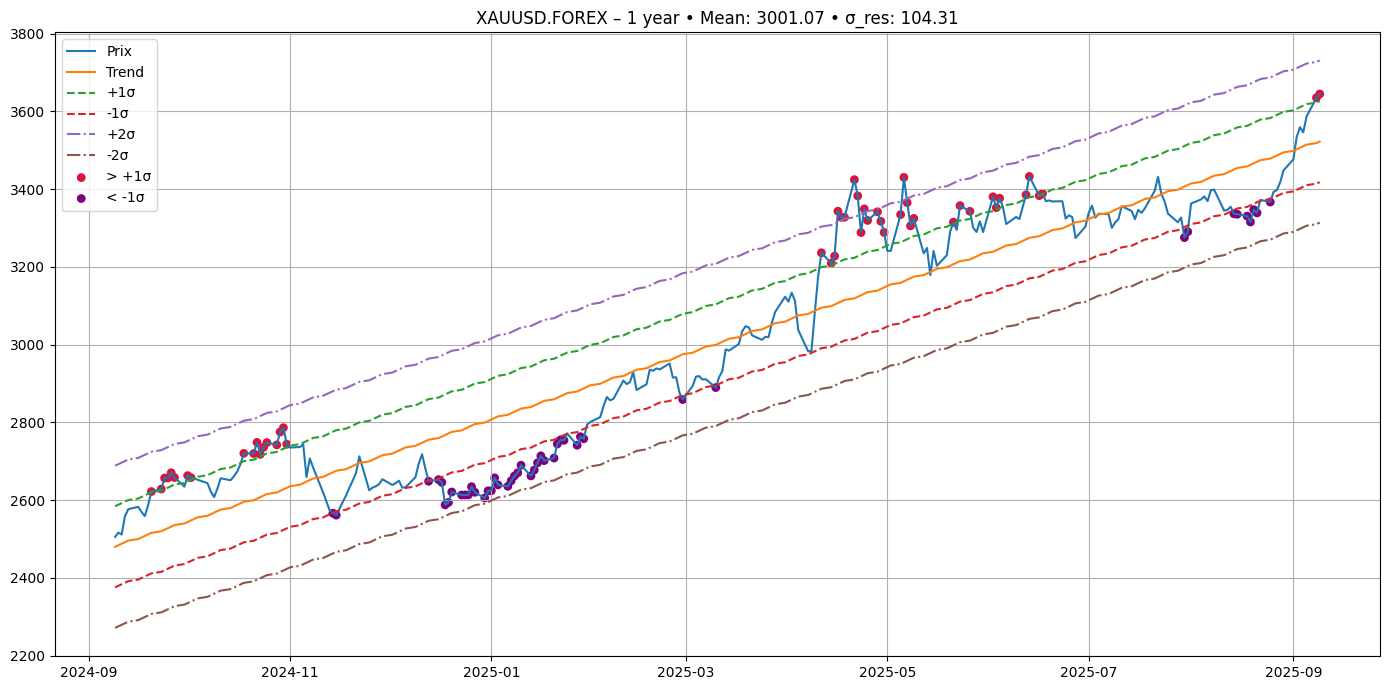

In [155]:
# OUTPUT

api_token = API_TOKEN
ticker = "XAUUSD.FOREX"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
start_1y = (pd.to_datetime(end_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
logger = Logger.setup()

# data collection and cleaning
data = get_daily_data(ticker, start_1y, end_date, API_TOKEN, logger).copy()
data = clean_data(data)

analysed_data = analysis(data, logger, True)


plot_with_quantification(data, f'{ticker} – 1 year')
